<a href="https://colab.research.google.com/github/sesael/time-series-forecasting/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor, plot_importance

from torch import nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import holoviews as hv
from holoviews import opts

from google.colab import files

In [2]:
!pip install kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edgardogomez","key":"1a9e6201e95c6ca442440b84c1d3be5d"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c acea-water-prediction

  0% 0.00/780k [00:00<?, ?B/s]
100% 780k/780k [00:00<00:00, 76.9MB/s]


In [7]:
!unzip acea-water-prediction

Archive:  acea-water-prediction.zip
  inflating: Aquifer_Auser.csv       
  inflating: Aquifer_Doganella.csv   
  inflating: Aquifer_Luco.csv        
  inflating: Aquifer_Petrignano.csv  
  inflating: Lake_Bilancino.csv      
  inflating: River_Arno.csv          
  inflating: Water_Spring_Amiata.csv  
  inflating: Water_Spring_Lupa.csv   
  inflating: Water_Spring_Madonna_di_Canneto.csv  
  inflating: datasets_description.ods  
  inflating: datasets_description.xlsx  


In [10]:
df = pd.read_csv('Lake_Bilancino.csv')
df

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31
...,...,...,...,...,...,...,...,...,...
6598,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.60
6599,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.60
6600,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.60
6601,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,250.82,0.60


There are many NaN Values in the river_arno dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


In [12]:
df.isna().sum()

,0
Date,0
Rainfall_S_Piero,577
Rainfall_Mangona,577
Rainfall_S_Agata,577
Rainfall_Cavallina,577
Rainfall_Le_Croci,577
Temperature_Le_Croci,578
Lake_Level,0
Flow_Rate,21


<Axes: >

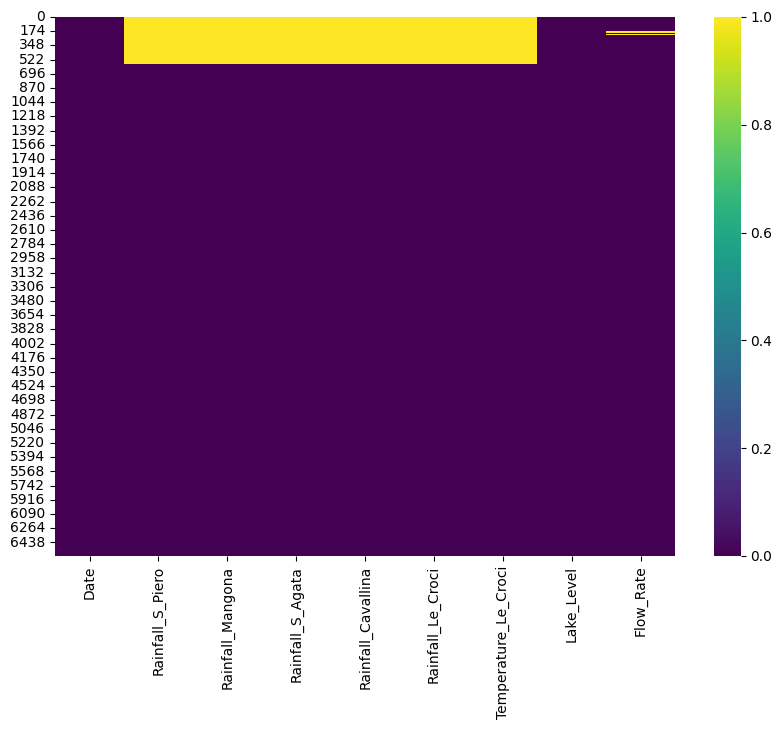

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cmap='viridis')

Since all the missing information is from the beginning of the dataset, I proceded to remove the first 577 rows.

In [14]:
df = df.dropna()
df.isna().sum()

,0
Date,0
Rainfall_S_Piero,0
Rainfall_Mangona,0
Rainfall_S_Agata,0
Rainfall_Cavallina,0
Rainfall_Le_Croci,0
Temperature_Le_Croci,0
Lake_Level,0
Flow_Rate,0


<Axes: >

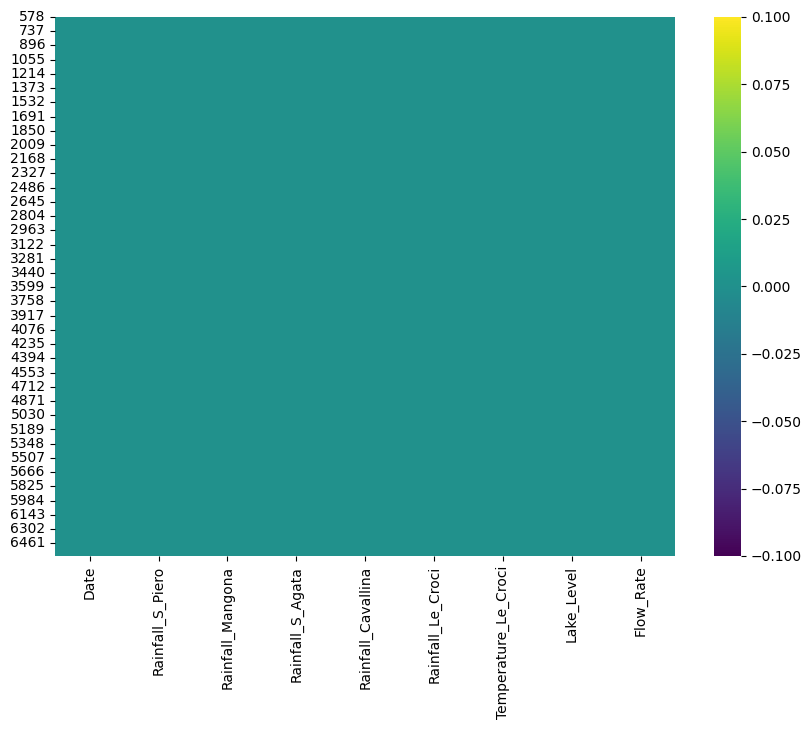

In [15]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cmap='viridis')

In [19]:
fig = px.line(df, x='Date',
              y= list(df.columns)[1:-3],
              title="Trends of Rainfall over Time",
              labels={'value': 'Values', 'variable': 'Features'},
              template="plotly")
fig.show()

In [20]:
fig = px.line(df, x='Date',
              y= list(df.columns)[-3:],
              title="Trends of Lake Level, Flow Rate, and Temperature over Time",
              labels={'value': 'Values', 'variable': 'Features'},
              template="plotly")
fig.show()

In [17]:
df.describe()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000
mean,2.471635,3.341212,2.670440,2.675187,3.130390,14.530141,249.553472,2.778204
std,6.650488,8.903769,7.167178,7.656404,8.025686,6.944029,2.183334,4.131176
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,243.530000,0.450000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,247.930000,0.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,250.240000,1.500000
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,251.370000,3.000000
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,252.760000,74.650000


Rainfall means the ammount of rain falling, in millimeters (mm) in a single area. Lets plot the information.

In [21]:
df_columns = list(df.columns)
df_rf_columns = [x for x in df_columns if x.startswith("Rainfall")]

In [22]:
fig = go.Figure()
for column in df_rf_columns:
    fig.add_trace(go.Violin(y=df[column], name = column))

fig.show()

We can see that most of the time rain has very small or 0 values in all sites.

Lets explore the Lake Level now.

In [23]:
px.scatter(df,
           x = "Date",
           y = "Lake_Level",
           color= "Lake_Level",
           color_continuous_scale=px.colors.sequential.Magenta)

Seems to be a seasonality present

Now lets revise the Flow Rate

In [24]:
px.scatter(df,
           x = "Date",
           y = "Flow_Rate",
           color= "Flow_Rate",
           color_continuous_scale=px.colors.sequential.Aggrnyl)

There seems to be a seasonality.

Finally, the temperature

In [25]:
px.box(df["Temperature_Le_Croci"],
           color_discrete_sequence=px.colors.sequential.Blues_r
       )

The median temperature in the river is 14.5 celsius.
The temperature reaches -5.35 celsius in winter and 34 celsius in the summer

In [26]:
px.scatter(df, y = df["Temperature_Le_Croci"], x= df["Date"], color_discrete_sequence=px.colors.sequential.Reds_r)

As in the other variables, a seasonality seems to be present

Now lets review the correlations between the variables

In [27]:
px.imshow(round(df.iloc[:,1:].corr(),2), width=1200, height=900, text_auto=True)

###Feature Engineering

In [29]:
columns_to_lag = list(df.columns)[1:]

#Creating lag features with a lag of 1, 2, and 3 days
lags = [1, 2, 3]

#Generating the lagged features and adding them to the dataframe
for column in columns_to_lag:
    for lag in lags:
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)

# Drop any rows with NaN values generated due to lagging
df = df.dropna().reset_index(drop=True)

<ipython-input-29-88ce017c05ba>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-88ce017c05ba>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-88ce017c05ba>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-88ce017

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate,Rainfall_S_Piero_lag_1,...,Rainfall_Le_Croci_lag_3,Temperature_Le_Croci_lag_1,Temperature_Le_Croci_lag_2,Temperature_Le_Croci_lag_3,Lake_Level_lag_1,Lake_Level_lag_2,Lake_Level_lag_3,Flow_Rate_lag_1,Flow_Rate_lag_2,Flow_Rate_lag_3
0,05/01/2004,0.2,0.0,0.0,0.0,0.0,0.90,251.37,0.5,0.0,...,0.0,2.00,4.45,6.50,251.35,251.28,251.21,0.5,0.5,0.5
1,06/01/2004,0.0,0.0,0.0,0.0,0.0,2.25,251.42,0.5,0.2,...,0.0,0.90,2.00,4.45,251.37,251.35,251.28,0.5,0.5,0.5
2,07/01/2004,0.0,0.0,0.0,0.0,0.0,3.65,251.43,0.5,0.0,...,0.0,2.25,0.90,2.00,251.42,251.37,251.35,0.5,0.5,0.5
3,08/01/2004,0.0,0.8,0.0,0.0,0.0,3.35,251.45,0.5,0.0,...,0.0,3.65,2.25,0.90,251.43,251.42,251.37,0.5,0.5,0.5
4,09/01/2004,4.6,5.8,3.8,5.6,7.8,5.55,251.49,0.5,0.0,...,0.0,3.35,3.65,2.25,251.45,251.43,251.42,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.6,0.0,...,0.0,22.35,22.15,22.50,250.87,250.86,250.86,0.6,0.6,0.6
6018,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.6,0.0,...,0.0,22.50,22.35,22.15,250.85,250.87,250.86,0.6,0.6,0.6
6019,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.6,0.0,...,0.0,23.40,22.50,22.35,250.84,250.85,250.87,0.6,0.6,0.6
6020,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,250.82,0.6,0.0,...,0.0,21.50,23.40,22.50,250.83,250.84,250.85,0.6,0.6,0.6


In [30]:
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate,Rainfall_S_Piero_lag_1,...,Rainfall_Le_Croci_lag_3,Temperature_Le_Croci_lag_1,Temperature_Le_Croci_lag_2,Temperature_Le_Croci_lag_3,Lake_Level_lag_1,Lake_Level_lag_2,Lake_Level_lag_3,Flow_Rate_lag_1,Flow_Rate_lag_2,Flow_Rate_lag_3
0,05/01/2004,0.2,0.0,0.0,0.0,0.0,0.90,251.37,0.5,0.0,...,0.0,2.00,4.45,6.50,251.35,251.28,251.21,0.5,0.5,0.5
1,06/01/2004,0.0,0.0,0.0,0.0,0.0,2.25,251.42,0.5,0.2,...,0.0,0.90,2.00,4.45,251.37,251.35,251.28,0.5,0.5,0.5
2,07/01/2004,0.0,0.0,0.0,0.0,0.0,3.65,251.43,0.5,0.0,...,0.0,2.25,0.90,2.00,251.42,251.37,251.35,0.5,0.5,0.5
3,08/01/2004,0.0,0.8,0.0,0.0,0.0,3.35,251.45,0.5,0.0,...,0.0,3.65,2.25,0.90,251.43,251.42,251.37,0.5,0.5,0.5
4,09/01/2004,4.6,5.8,3.8,5.6,7.8,5.55,251.49,0.5,0.0,...,0.0,3.35,3.65,2.25,251.45,251.43,251.42,0.5,0.5,0.5


In [33]:
columns_to_roll =list(df.columns)[1:7]
columns_to_roll

['Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci']

In [34]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [37]:
#Lets calculate the rolling window statistics (mean, sum) for the columns to roll, grouped by month
for column in columns_to_roll:
    df[f'{column}_monthly_mean'] = df.groupby(df['Date'].dt.to_period('M'))[column].transform('mean')
    df[f'{column}_monthly_sum'] = df.groupby(df['Date'].dt.to_period('M'))[column].transform('sum')

In [42]:
#Now, let's create date-based features from the 'Date' column
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_month'] = df['Date'].dt.day
df['season'] = df['Date'].dt.month % 12 // 3

In [45]:
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate,Rainfall_S_Piero_lag_1,...,Rainfall_Cavallina_monthly_sum,Rainfall_Le_Croci_monthly_mean,Rainfall_Le_Croci_monthly_sum,Temperature_Le_Croci_monthly_mean,Temperature_Le_Croci_monthly_sum,year,month,day_of_week,day_of_month,season
0,2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,251.37,0.5,0.0,...,115.2,3.888889,105.0,4.181481,112.9,2004,1,0,5,0
1,2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,251.42,0.5,0.2,...,115.2,3.888889,105.0,4.181481,112.9,2004,1,1,6,0
2,2004-01-07,0.0,0.0,0.0,0.0,0.0,3.65,251.43,0.5,0.0,...,115.2,3.888889,105.0,4.181481,112.9,2004,1,2,7,0
3,2004-01-08,0.0,0.8,0.0,0.0,0.0,3.35,251.45,0.5,0.0,...,115.2,3.888889,105.0,4.181481,112.9,2004,1,3,8,0
4,2004-01-09,4.6,5.8,3.8,5.6,7.8,5.55,251.49,0.5,0.0,...,115.2,3.888889,105.0,4.181481,112.9,2004,1,4,9,0


###Splitting the Dataset

In [46]:
#Lets define the cutoff date for training
train_cutoff_date = '2018-06-30'

#Splitting the data into training and testing sets
train_df = df[df['Date'] <= train_cutoff_date]
test_df = df[df['Date'] > train_cutoff_date]

In [48]:
#Shape of the training and testing set
(train_df.shape[0], test_df.shape[0])

(5291, 731)

In [53]:
#Separating the features into X and Y
X_train = train_df.drop(columns=['Lake_Level', 'Flow_Rate', 'Date'])
y_train = train_df[['Lake_Level', 'Flow_Rate']]

X_test = test_df.drop(columns=['Lake_Level', 'Flow_Rate', 'Date'])
y_test = test_df[['Lake_Level', 'Flow_Rate']]

In [51]:
#Stablishing the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [52]:
#Fitting the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
#Preicting outputs
y_pred = model.predict(X_test)

In [58]:
#Calculating RMSE for each target variable
rmse_lake_level = root_mean_squared_error(y_test['Lake_Level'], y_pred[:, 0])
rmse_flow_rate = root_mean_squared_error(y_test['Flow_Rate'], y_pred[:, 1])

rmse_lake_level, rmse_flow_rate

(0.0847280186464554, 1.6418818597071267)

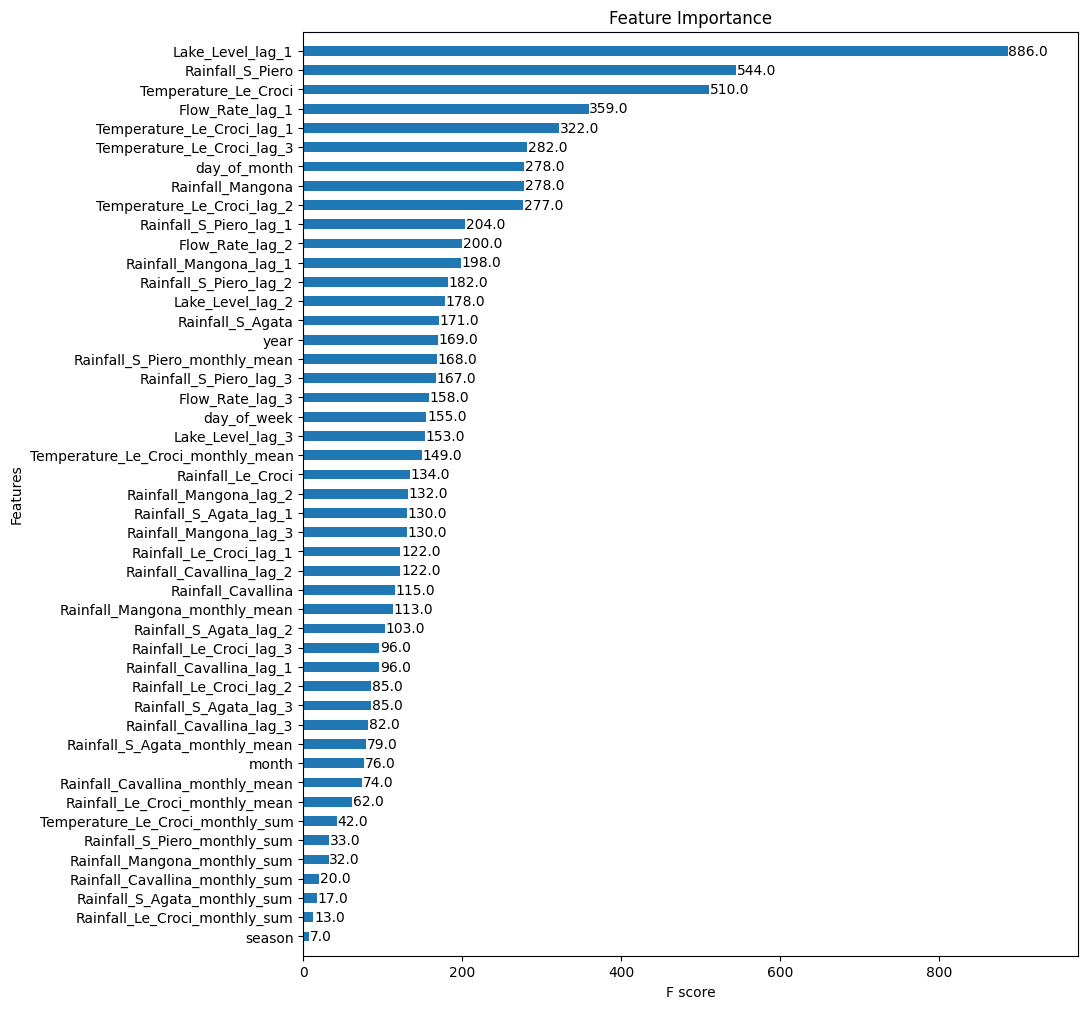

In [67]:
#Feature importance
fig, ax = plt.subplots(figsize=(10, 12))  # Adjust size as needed
plot_importance(model, importance_type='weight', ax=ax, height=0.5, grid=False)
plt.title('Feature Importance')
plt.show()

Now lets take a look at the residual values

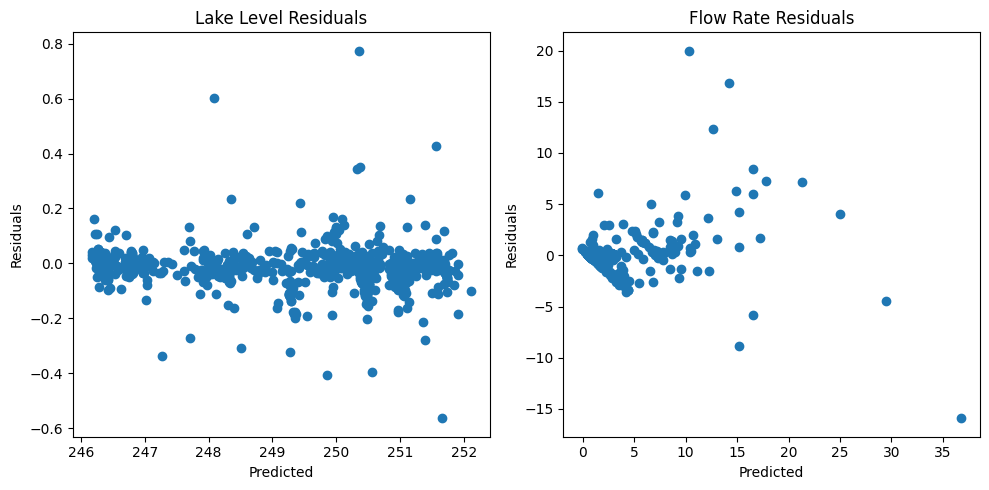

In [68]:
residuals_lake_level = y_test['Lake_Level'] - y_pred[:, 0]
residuals_flow_rate = y_test['Flow_Rate'] - y_pred[:, 1]

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred[:, 0], residuals_lake_level)
plt.title("Lake Level Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(y_pred[:, 1], residuals_flow_rate)
plt.title("Flow Rate Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

###Hyperparameter Optimization using Grid Search

In [70]:
#Defining the grid of hyperparameters
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

#Defining the gridsearch
grid_search = GridSearchCV(estimator=model, param_grid=parameters,
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

In [72]:
#Fitting the grid search
grid_search.fit(X_train, y_train)

#Getting the best parameters
best_params = grid_search.best_params_
print(f"The best parameters for the model are: {best_params}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
The best parameters for the model are: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}


In [74]:
#Using the best parameters to re-train the model
best_model = grid_search.best_estimator_

In [76]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [77]:
#Re-training the model with the best estimators
y_pred = best_model.predict(X_test)

In [78]:
rmse_lake_level = root_mean_squared_error(y_test['Lake_Level'], y_pred[:, 0])
rmse_flow_rate = root_mean_squared_error(y_test['Flow_Rate'], y_pred[:, 1])


In [81]:
# Calculate MAE for each target
mae_lake_level = mean_absolute_error(y_test['Lake_Level'], y_pred[:, 0])
mae_flow_rate = mean_absolute_error(y_test['Flow_Rate'], y_pred[:, 1])

In [82]:
r2_lake_level = r2_score(y_test['Lake_Level'], y_pred[:, 0])
r2_flow_rate = r2_score(y_test['Flow_Rate'], y_pred[:, 1])

In [83]:
print(f"RMSE (Lake Level): {rmse_lake_level}")
print(f"RMSE (Flow Rate): {rmse_flow_rate}")
print(f"MAE (Lake Level): {mae_lake_level}")
print(f"MAE (Flow Rate): {mae_flow_rate}")
print(f"R² (Lake Level): {r2_lake_level}")
print(f"R² (Flow Rate): {r2_flow_rate}")

RMSE (Lake Level): 0.09481697275571334
RMSE (Flow Rate): 1.631105744761199
MAE (Lake Level): 0.062363520881871436
MAE (Flow Rate): 0.4570851379005103
R² (Lake Level): 0.9968180478817825
R² (Flow Rate): 0.8219882641190869


Lets check the residuals again

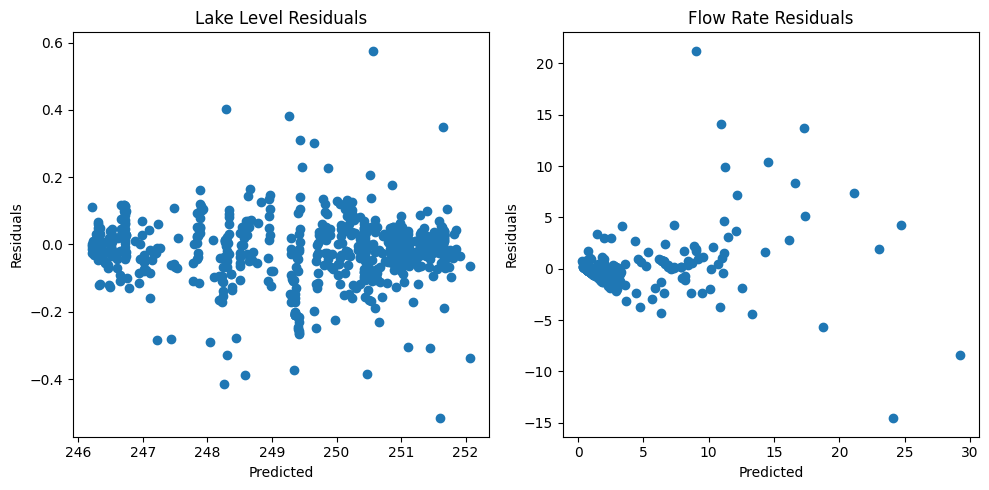

In [84]:
residuals_lake_level = y_test['Lake_Level'] - y_pred[:, 0]
residuals_flow_rate = y_test['Flow_Rate'] - y_pred[:, 1]

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred[:, 0], residuals_lake_level)
plt.title("Lake Level Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(y_pred[:, 1], residuals_flow_rate)
plt.title("Flow Rate Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

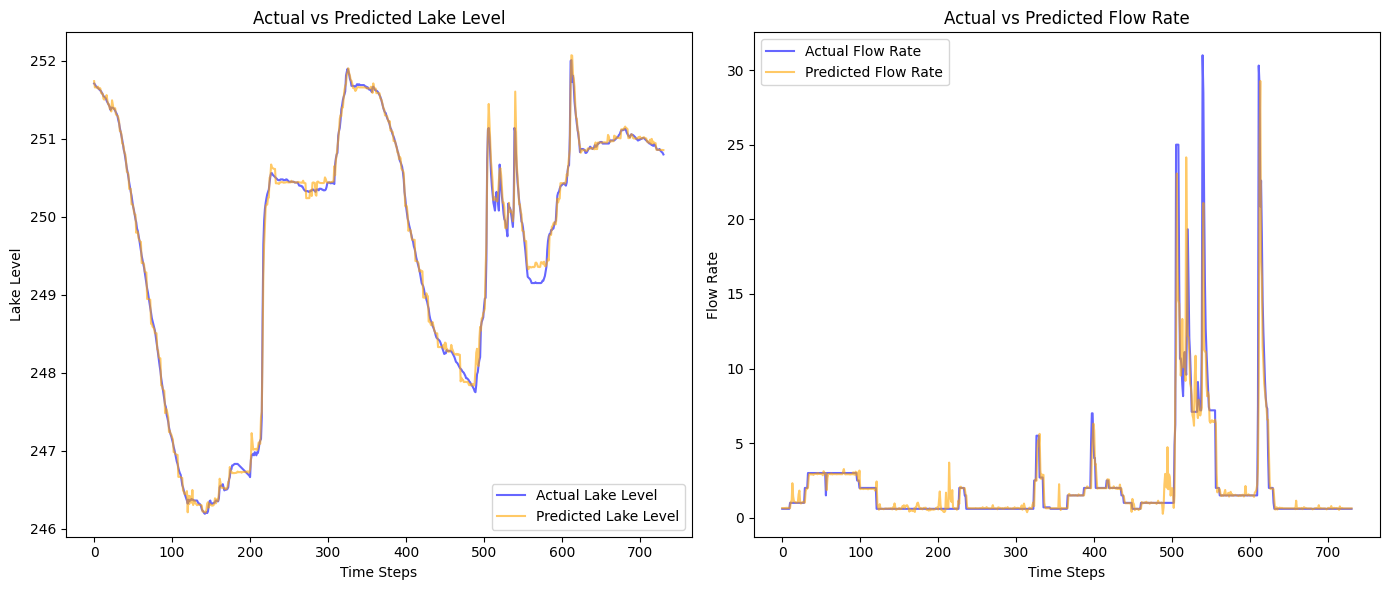

In [85]:
#Plotting Actual vs Predicted values for both Lake Level and Flow Rate
plt.figure(figsize=(14,6))

# Subplot 1: Lake Level (Actual vs Predicted)
plt.subplot(1, 2, 1)
plt.plot(y_test['Lake_Level'].values, label='Actual Lake Level', color='blue', alpha=0.6)
plt.plot(y_pred[:, 0], label='Predicted Lake Level', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Lake Level')
plt.xlabel('Time Steps')
plt.ylabel('Lake Level')
plt.legend()

#Subplot 2: Flow Rate (Actual vs Predicted)
plt.subplot(1, 2, 2)
plt.plot(y_test['Flow_Rate'].values, label='Actual Flow Rate', color='blue', alpha=0.6)
plt.plot(y_pred[:, 1], label='Predicted Flow Rate', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Flow Rate')
plt.xlabel('Time Steps')
plt.ylabel('Flow Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
#Showing the comparison in Plotly

results_df = pd.DataFrame({
    'Actual Lake Level': y_test['Lake_Level'].values,
    'Predicted Lake Level': y_pred[:, 0],
    'Actual Flow Rate': y_test['Flow_Rate'].values,
    'Predicted Flow Rate': y_pred[:, 1],
    'Time Steps': range(len(y_test))
})

fig1 = px.line(results_df, x='Time Steps', y=['Actual Lake Level', 'Predicted Lake Level'],
               title='Actual vs Predicted Lake Level',
               labels={'value': 'Lake Level', 'Time Steps': 'Time Steps'},
               template='plotly')
fig2 = px.line(results_df, x='Time Steps', y=['Actual Flow Rate', 'Predicted Flow Rate'],
               title='Actual vs Predicted Flow Rate',
               labels={'value': 'Flow Rate', 'Time Steps': 'Time Steps'},
               template='plotly')
fig1.show()
fig2.show()